In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.io import fits
import scipy.sparse
import scipy.linalg

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log

z = 2
z2 = (1 + z) / 3

In [2]:
with open('rate_10Mpc.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [5]:
def compton_f(x):
    if x > 1e-2:
        return ((-24 - 144*x - 290*x**2 - 194*x**3 + 20*x**4 + 28*x**5) / 3 / x**2 / (1+2*x)**3 + (4+4*x-x**2) / x**3 * np.log(1+2*x))
    return 8/5*x**2 - 32/5*x**3 + 2248/105*x**4 - 1376/21*x**5 + 11840/63*x**6

def compton_FF(x):
    n = 1024
    y = np.linspace(x / (2 * n), x - x / (2 * n), n)
    result = 0.
    for i in range(n): result += compton_f(y[i]) * y[i]
    result *= x / n
    return result

In [6]:
jtable = np.loadtxt('EBL_KS18_Q20_z_ 2.0.txt')
nstep = np.shape(jtable)[0] - 1
jtable[:,0] = 2.99792458e18 / jtable[:,0] # convert to Hz
nu = (jtable[:-1,0] + jtable[1:,0]) / 2
dnu = (jtable[:-1,0] - jtable[1:,0])
JnuEBL = (jtable[:-1,1] + jtable[1:,1]) / 2

xx = h*nu/k/T_CMB
Bnu = 2 * h * nu**3 / c**2 / np.expm1(xx)
Jnu = JnuEBL + Bnu

/var/folders/k2/qxng019s7y17hp_kgkzy9b180000gn/T/ipykernel_24459/3569518853.py:9: RuntimeWarning: overflow encountered in expm1
  Bnu = 2 * h * nu**3 / c**2 / np.expm1(xx)


In [7]:
n = 400

prefix_sums = [0 for _ in range(n)] # theta_rms from gamma_jp to gamma_j = np.sqrt(prefix[j] - prefix[jp+1])

for j in range(n-1, -1, -1):
    all_int = 0
    factors = Bnu / nu**3 * dnu
    for k in range(nstep):
        all_int += compton_FF(2 * gamma_e_arr[j] * h * nu[k] / m_e / c**2) * factors[k]

    tp2 = 135 * m_e * c**2 / 128 / np.pi**4 / gamma_e_arr[j]**3 * (m_e * c**2 / k / T_CMB)**4 * all_int
    sumi = tp2 / (m_e * c * gamma_e_arr[j])**2 * np.log(gamma_e_arr[1] / gamma_e_arr[0])

    prefix_sums[j] = sumi

    if j + 1 < n:
        prefix_sums[j] += prefix_sums[j + 1]

In [12]:
np.save("prefix_sums.npy", prefix_sums)

In [8]:
def calculate_solid_angles(theta):
    # theta_half[i] = theta[i-1/2]
    theta_half = (theta[1:] + theta[:-1]) / 2
    theta_half = np.concatenate([[theta[0]/2], theta_half, [3*theta[-1]/2 - theta[-2]/2]])

    Omega = 2 * np.pi * (theta_half[2:]**2 - theta_half[:-2]**2) / 2  # solid angles of annulus
    Omega = np.concatenate([Omega, [2 * np.pi * (theta[-1]**2 - theta_half[-2]**2)]])  # add the last circle

    return Omega, theta_half

In [9]:
Omega, theta_half = calculate_solid_angles(theta_e_arr)

In [10]:
M = np.zeros((400, 400))

for i in range(1, 399):
    for j in range(400):
        if j == i + 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i])
        if j == i:
            M[i, j] = 2 * np.pi / Omega[i] * (theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i]) + theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1]))
        if j == i - 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1])

M[0, 0] = 0
M[-1, -1] = 0

In [13]:
def get_nij(i, j, t): # nij = dN / (dV dgammae_j dOmegae_i)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_max_inv = 1. / gamma_e_arr[j] - Gamma_IC0 * t
    if gamma_max_inv>1e-99:
        gamma_max = 1./gamma_max_inv
    else:
        gamma_max = 1e99
        
    nij = 0
    
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            theta_rms = np.sqrt(prefix_sums[j] - prefix_sums[jp+1])
            M_expm = scipy.linalg.expm(theta_rms**2/4 * M)
            # THIS IS A COMMENT: rate_trans_smoothed = M_expm @ rate_trans
            # Then, rate_trans_smoothed[i][jp] is the dot product of M_expm[i] and rate_trans[:, jp]
            rate_trans_smoothed_ijp = np.dot(M_expm[i, :], rate_trans[:, jp])
                
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans_smoothed_ijp
            
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                sum_ij = sum_ij * fraction
            nij += sum_ij
    nij = nij / (Gamma_IC0 * gamma_e_arr[j]**2)
    return nij

In [14]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [15]:
#t_arr = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12, 5e12, 1e13]
t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13]
t_num = len(t_arr)

In [16]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [22]:
import time

time_start = time.time()

nij = np.zeros((t_num, 400, 400)) # t theta[i] gamma[j]
for k in range(t_num):
    print(f'time {k} {t_arr[k]:.1e}', end=' ')
    for i in range(400):
        for j in range(1, 400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k])
    print('t = ', (time.time() - time_start) / 60)

time 0 1.0e+08 t =  28.666046516100565
time 1 1.0e+09 t =  64.7957969824473
time 2 1.0e+10 t =  174.84971308310827
time 3 1.0e+11 t =  560.9184460202853
time 4 1.0e+12 t =  1513.9496595184007
time 5 1.0e+13 

KeyboardInterrupt: 

In [23]:
np.save("nij.npy", nij)

In [24]:
loaded_data = np.load("nij.npy")

In [27]:
ni = np.zeros((t_num-1, 400)) # about theta
for k in range(t_num-1):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])

In [28]:
deriv_array = np.zeros((400,t_num-1))
for j in range(399):
    for jp in range(j,399):
        if j==jp:
            tr = 0.
        else:
            tr = np.arccosh(theta_e_arr[jp]/theta_e_arr[j])
        deriv_array[j,:] += 2 * theta_e_arr[j] * (ni[:,jp+1]-ni[:,jp])/(theta_e_arr[jp+1]-theta_e_arr[jp])\
            * (np.arccosh(theta_e_arr[jp+1]/theta_e_arr[j]) - tr)

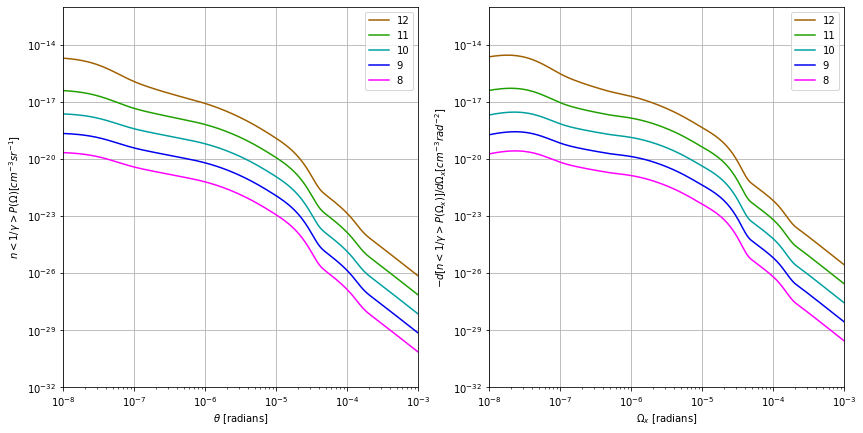

In [37]:
from matplotlib import cm

# Load data from files
#ni_data = np.loadtxt('ni.dat')
#deriv_array_data = np.loadtxt('deriv_array.dat')

# Prepare subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# First subplot
ax1 = axs[0]
ax1.set_xlabel(r'$\theta$ [radians]')
ax1.set_ylabel(r'$n<1/\gamma>P(\Omega) [cm^{-3} sr^{-1}]$')
ax1.grid(True)

colors = ['#a06000', '#20a000', '#00a0a0', '#0000ee', '#ff00ff']
labels = ["12", "11", "10", "9", "8"]
columns = [4, 3, 2, 1, 0]

for color, label, column in zip(colors, labels, columns):
    ax1.plot(theta_e_arr, ni[column], color=color, label=label)

ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-8, 1e-3])
ax1.set_ylim([1e-32, 1e-12])

# Second subplot
ax2 = axs[1]
ax2.set_xlabel(r'$\Omega_x$ [radians]')
ax2.set_ylabel(r'$-d[n<1/\gamma>P(\Omega_x)]/d\Omega_x [cm^{-3} rad^{-2}]$')
ax2.grid(True)

for color, label, column in zip(colors, labels, columns):
    ax2.plot(Omega_x, -deriv_array[:, column], color=color, label=label)

ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-8, 1e-3])
ax2.set_ylim([1e-32, 1e-12])

# Show the plot
plt.show()
